<a href="https://colab.research.google.com/github/khadijakhaldi/Coursera-Getting-and-Cleaning-Data-course-project/blob/master/Drill_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

we'll start by importing all the necessary modules.

In [2]:
import torch
import cv2
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Next, we'll set the random seeds for reproducability.

In [98]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Dataset creation

the first step we need to do is to extract the images from the videos

To handle custom datasets, torchvision provides a [`datasets.ImageFolder`](https://pytorch.org/vision/stable/datasets.html#torchvision.datasets.ImageFolder) class. 

`ImageFolder` expects data to be stored in the following way:

```
root/class_x/xxy.png
root/class_x/xxz.jpg

root/class_y/123.jpeg
root/class_y/nsdf3.png
root/class_y/asd932_.jpg
```
That is, each folder in the root directory='data/data_frames' is the name of a class, and within each of those folders are the images that correspond to that class. The images that we will extract from the videos will be in the form of:

```
data/data_frames/2.0 mm x 26 mm/image_1.jpg
data/data_frames/2.0 mm x 26 mm/image_2.jpg

data/data_frames/2.0 mm x 28 mm/image_1.jpg
data/data_frames/2.0 mm x 28 mm/image_2.jpg

data/data_frames/2.8 mm x 22 mm/image_1.jpg
data/data_frames/2.8 mm x 22 mm/image_2.jpg
```


In [4]:
def extractFrames(m,n):
    if not os.path.exists:
        os.makedirs(n)

    vid_files=os.listdir(m)
    print(vid_files)

    for v_f in range(len(vid_files)):
        v1= os.path.basename(vid_files[v_f])
        vid_name_0 = os.path.splitext(v1)[0]
        vid_name = vid_name_0[0]+'.'+vid_name_0[1]+' mm x '+vid_name_0[3:5]+' mm'
        output = os.path.join(n,vid_name)
        if not os.path.exists(output):
            os.makedirs(output)

        vid_path = os.path.join(m,v1)
        vidcap = cv2.VideoCapture(vid_path)
        success,image = vidcap.read()
        count=0
        while success:
            img_name = vid_name_0[5:]+'_f' + str(count) + ".jpg"
            image_path = output + "/" + img_name
            frameId = int(round(vidcap.get(1)))
            cv2.imwrite(filename = image_path, img = image)
            count+=1
            success, image = vidcap.read()

        vidcap.release()
        cv2.destroyAllWindows()

        print('finished processing video {0} with frames {1}'.format(vid_files[v_f], count))
    return output

In [5]:
input = '/content/drive/MyDrive/ML Assessment Data'
output = '/content/data/data_frames/'
extractFrames(input,output)

['20x26dark.mp4', '20x26light.mp4', '20x28dark.mp4', '20x28light.mp4', '28x22dark.mp4', '28x22light.mp4', '35x19dark.mp4', '35x19light.mp4', '35x22dark.mp4', '35x22light.mp4', '35x28dark.mp4', '35x28light.mp4', '35x30dark.mp4', '35x30light.mp4', '42x22dark.mp4', '42x22light.mp4', '42x30dark.mp4', '42x30light.mp4']
finished processing video 20x26dark.mp4 with frames 1211
finished processing video 20x26light.mp4 with frames 1617
finished processing video 20x28dark.mp4 with frames 1211
finished processing video 20x28light.mp4 with frames 979
finished processing video 28x22dark.mp4 with frames 1211
finished processing video 28x22light.mp4 with frames 970
finished processing video 35x19dark.mp4 with frames 1211
finished processing video 35x19light.mp4 with frames 964
finished processing video 35x22dark.mp4 with frames 1211
finished processing video 35x22light.mp4 with frames 970
finished processing video 35x28dark.mp4 with frames 1211
finished processing video 35x28light.mp4 with frames 964

'/content/data/data_frames/4.2 mm x 30 mm'

### Split data into train/test

 Now let's split our data into train and test splits. This could be done with data.random_split.

We first set a TRAIN_RATIO which will decide what percentage of the images per class are used to make up the training set, with the remainder making up the test set. 

We create a train and test folder within the data folder. Then, we get a list of all classes and loop through each class. For each class we get the image names, use the first TRAIN_RATIO of them for the training set and the remainder for the test set. We then copy - with shutil.copyfile - each of the images into their respective train or test folder. It is usually better to copy, rather than move, the images to create your custom splits just in case we accidentally mess up somewhere.

After running the below cell we have our training set as:

```
data/train/2.0 mm x 26 mm/image_1.jpg
data/train/2.0 mm x 26 mm/image_2.jpg

data/train/2.0 mm x 28 mm/image_1.jpg
data/train/2.0 mm x 28 mm/image_2.jpg

data/train/2.8 mm x 22 mm/image_1.jpg
data/train/2.8 mm x 22 mm/image_2.jpg
```

and our test set as:

```
data/test/2.0 mm x 26 mm/image_10.jpg
data/test/2.0 mm x 26 mm/image_20.jpg

data/test/2.0 mm x 28 mm/image_10.jpg
data/test/2.0 mm x 28 mm/image_20.jpg

data/test/2.8 mm x 22 mm/image_10.jpg
data/test/2.8 mm x 22 mm/image_20.jpg
```

In [6]:
ROOT = '/content'
TRAIN_RATIO = 0.8

data_dir = os.path.join(ROOT, 'data')
images_dir = os.path.join(data_dir, 'data_frames')
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

In [7]:
if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)

os.makedirs(train_dir)
os.makedirs(test_dir)

classes = os.listdir(images_dir)

for c in classes:

    class_dir = os.path.join(images_dir, c)

    images = os.listdir(class_dir)

    n_train = int(len(images) * TRAIN_RATIO)

    train_images = images[:n_train]
    test_images = images[n_train:]

    os.makedirs(os.path.join(train_dir, c), exist_ok=True)
    os.makedirs(os.path.join(test_dir, c), exist_ok=True)

    for image in train_images:
        image_src = os.path.join(class_dir, image)
        image_dst = os.path.join(train_dir, c, image)
        shutil.copyfile(image_src, image_dst)

    for image in test_images:
        image_src = os.path.join(class_dir, image)
        image_dst = os.path.join(test_dir, c, image)
        shutil.copyfile(image_src, image_dst)

### Data Normalization

Now we've got our train/test splits we can go ahead and calculate the mean and standard deviation (std) of our dataset to normalize it. 

In this notebook we will be using a pretrained model with fine tuning its last layer. Therefore, we will be using the mean and std desired by the pre-trained data, so we don't actually have to calculate this.
However, if we need to train the model from scratch we will need to run the next cells.

First, we load the train_data from the train folder. This will load PIL images by default so we pass the ToTensor transform which converts all the PIL images to tensors and scales them from 0-255 to 0-1.

We then loop through each image and calculate the mean and std across the height and width dimensions with dim = (1,2), summing all the means and stds and then finding the average by dividing them by the number of examples, len(train_data).

In [8]:
train_data = datasets.ImageFolder(root=train_dir,transform=transforms.ToTensor())

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_data:
    means += torch.mean(img, dim=(1, 2))
    stds += torch.std(img, dim=(1, 2))

means /= len(train_data)
stds /= len(train_data)

print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: tensor([0.5055, 0.5209, 0.4971])
Calculated stds: tensor([0.3337, 0.3308, 0.3251])


### Data Augmentation

Now to actually load our data. As we are going to be using a pre-trained model we will need to ensure that our images are the same size and have the same normalization as those used to train the model - which we find on the torchvision [models](https://pytorch.org/vision/stable/models.html) page.

We use data augmentation(randomly rotating, flipping horizontally and cropping) to increase the size of the dataset and introduce variability in the dataset, without actually collecting new data.

In [25]:
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding = 10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means,
                                                std = pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means,
                                                std = pretrained_stds)
                       ])

We load our data with our transforms

In [26]:
#We load our data with our transforms
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = train_transforms)

test_data = datasets.ImageFolder(root = test_dir,
                                 transform = test_transforms)

Number of training examples: 14594
Number of validation examples: 1622
Number of testing examples: 4058


### Create validation data

We create the validation set

In [ ]:
#create the validation split
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

then overwrite the validation transforms, making sure to do a deepcopy to stop this also changing the training data transforms.

In [99]:
#overwrite the validation transforms
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

To make sure nothing has messed up we'll print the number of examples in each of the data splits - ensuring they add up to the number of examples in our dataset.

In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

### Create data loaders

Next, we'll create the iterators with the largest batch size that fits on our GPU. 

In [27]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data,
                                 shuffle = True,
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size = BATCH_SIZE)

To ensure the images have been processed correctly we can plot a few of them.

In [28]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image


In [29]:
def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

We can see the images look fine

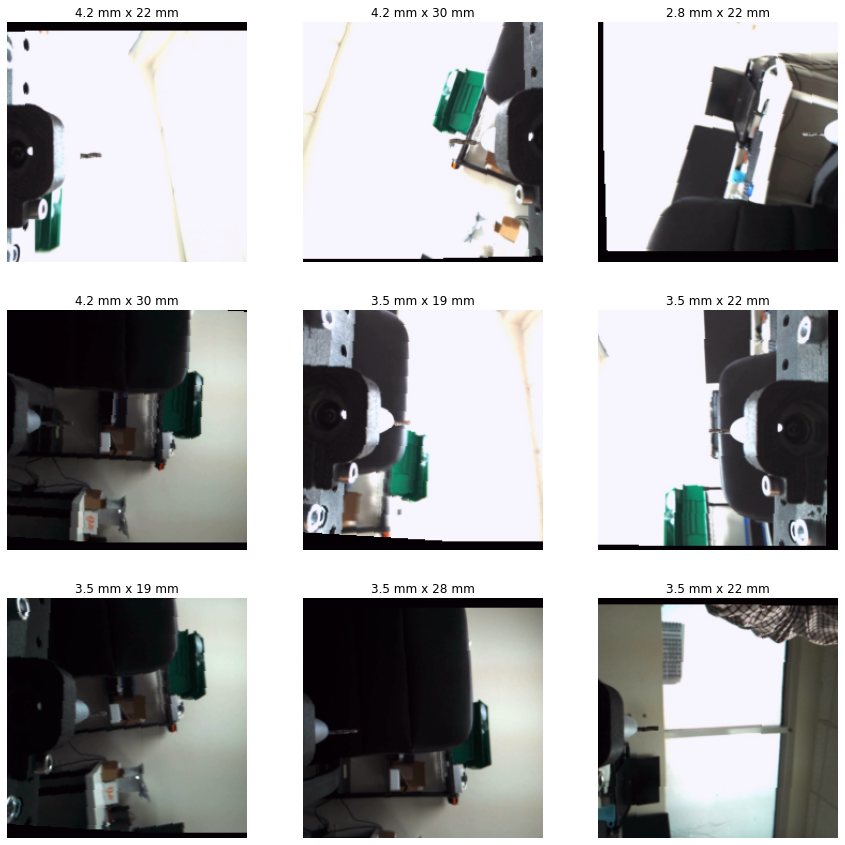

In [30]:
N_IMAGES = 10

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes)

### Defining the Model

In this project, we'll be using one of the residual network (ResNet) models. 

ResNet has multiple *configurations* which specify the number of layers and the sizes of those layers. Each layer is made out of *blocks*, which are made up of convolutional layers, batch normalization layers and *residual connections* (also called *skip connections* or *shortcut connections*).

A residual connection is simply a direct connection between the input of a block and the output of a block. Sometimes the residual connection has layers in it, but most of the time it does not. Below is an example block with an identity residual connection, i.e. no layers in the residual path.

The different ResNet configurations are known by the total number of layers within them - ResNet18, ResNet34, ResNet50, ResNet101 and ResNet152. In this project, we will use Resnet50.

Torchvision provides pre-trained models for all of the standard ResNet variants. First, we load the pre-trained ResNet model.

In [100]:
model = models.resnet50(pretrained = True)


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The final linear layer for the classification in resnet50 has a 1000-dimensional output.


Our dataset, however, only has 9 classes, so we first create a new linear layer with the required dimensions.

In [101]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

we first create a new linear layer with the required dimensions.

In [32]:
IN_FEATURES = model.fc.in_features 
OUTPUT_DIM = len(test_data.classes)

fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
print(OUTPUT_DIM)

9


Then, we replace the pre-trained model's linear layer with our own, randomly initialized linear layer.

In [33]:
model.fc = fc

### Training the Model

Next we'll move on to training our model.

We start by initializing an optimizer, defining a loss function (`criterion`) and device, and then placing the model and the loss function on to the device.

In [34]:
EPOCHS = 7
#optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#Loss function
criterion = nn.CrossEntropyLoss()
model = model.to(device)
criterion = criterion.to(device)

Now, let's define our train and test functions

In [72]:
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.train()

    for (x, y) in iterator:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
          outputs = model(x)
          _,y_preds = torch.max(outputs, 1)
          loss = criterion(outputs, y)
          loss.backward()
          optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += torch.sum(y_preds == y)

    epoch_loss /= len(iterator)
    epoch_acc = epoch_acc.double()/len(train_data)

    return epoch_loss, epoch_acc


In [73]:
def evaluate(model, iterator, criterion, device,phase):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()
    if phase=='val':
      data_size = len(valid_data)
    else:
      data_size = len(test_data)

    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)

            outputs = model(x)
            _,y_preds = torch.max(outputs, 1)
            loss = criterion(outputs, y)

            epoch_loss += loss.item()
            epoch_acc += torch.sum(y_preds == y)


    epoch_loss /= len(iterator)
    epoch_acc = epoch_acc.double() / data_size

    return epoch_loss, epoch_acc


Next, a small helper function which tells us how long an epoch has taken.

In [74]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally, we can train our model!

In [75]:
best_valid_loss = float('inf')

for epoch in range(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device,'val')

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'drail_bit-model.pt',_use_new_zipfile_serialization=False)

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc * 100:6.2f}%' )
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc * 100:6.2f}%' )

Epoch: 01 | Epoch Time: 6m 37s
	Train Loss: 0.009 | Train Acc @1:  99.92%
	Valid Loss: 0.003 | Valid Acc @1: 100.00%
Epoch: 02 | Epoch Time: 6m 37s
	Train Loss: 0.011 | Train Acc @1:  99.94%
	Valid Loss: 0.003 | Valid Acc @1: 100.00%
Epoch: 03 | Epoch Time: 6m 35s
	Train Loss: 0.010 | Train Acc @1:  99.90%
	Valid Loss: 0.002 | Valid Acc @1: 100.00%
Epoch: 04 | Epoch Time: 6m 34s
	Train Loss: 0.014 | Train Acc @1:  99.92%
	Valid Loss: 0.002 | Valid Acc @1: 100.00%
Epoch: 05 | Epoch Time: 6m 35s
	Train Loss: 0.016 | Train Acc @1:  99.92%
	Valid Loss: 0.002 | Valid Acc @1: 100.00%
Epoch: 06 | Epoch Time: 6m 37s
	Train Loss: 0.009 | Train Acc @1:  99.97%
	Valid Loss: 0.002 | Valid Acc @1: 100.00%
Epoch: 07 | Epoch Time: 6m 36s
	Train Loss: 0.011 | Train Acc @1:  99.91%
	Valid Loss: 0.002 | Valid Acc @1: 100.00%


Lets now test the model on the unseen test data. The model is achiveing 100% in accuarcy.

In [76]:
model.load_state_dict(torch.load('drail_bit-model.pt'))

test_loss, test_acc= evaluate(model, test_iterator, criterion, device,'test')

print(f'Test Loss: {test_loss:.3f} | Test Acc @1: {test_acc*100:6.2f}%')

Test Loss: 0.002 | Test Acc @1: 100.00%


### Exploring the Model results

First, we get the predictions for each image in the test set...

In [77]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [78]:
images, labels, probs = get_predictions(model, test_iterator)

which we then use to get the predicted labels.

In [79]:
pred_labels = torch.argmax(probs, 1)

We then use this to plot a confusion matrix.


In [80]:
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (15, 15));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    fig.delaxes(fig.axes[1]) #delete colorbar
    plt.xticks(rotation = 90)
    plt.xlabel('Predicted Label', fontsize = 15)
    plt.ylabel('True Label', fontsize = 15)


all we care about is that the diagonals are generally darker than the rest of the matrix - which they are.

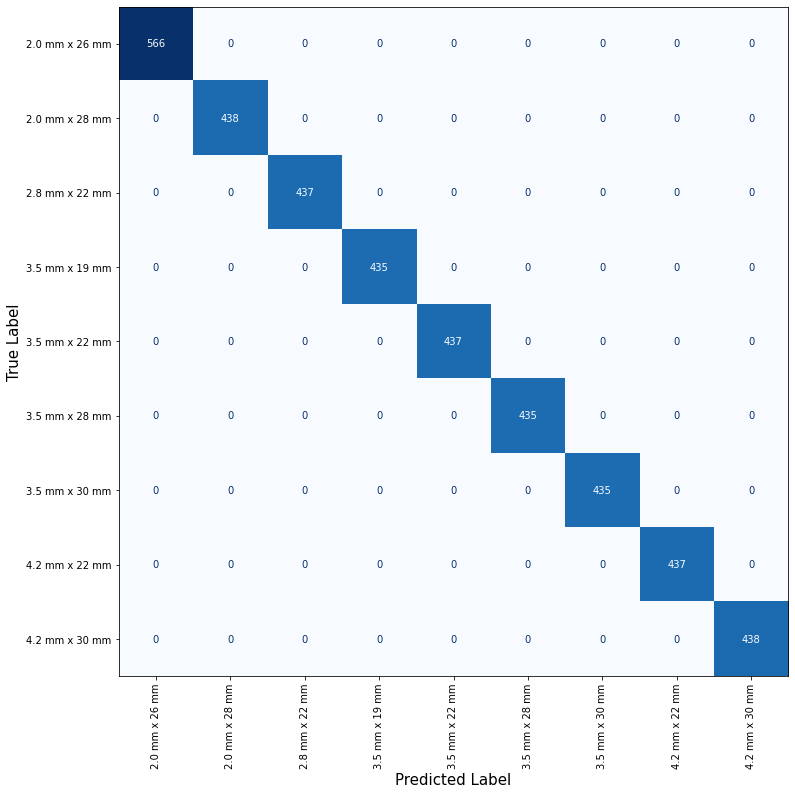

In [81]:
plot_confusion_matrix(labels, pred_labels, classes)

Lets get the correct classified examples and visualize them.
We can also get the incorrect classified samples with the same code (however we dont have them.)

In [82]:
corrects = torch.eq(labels, pred_labels)

In [83]:
correct_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if correct:
        correct_examples.append((image, label, prob))

correct_examples.sort(reverse = False, key = lambda x: torch.max(x[2], dim = 0).values)

We can then plot some of the correctly predicted images along with the predicted class and the actual class.

In [84]:
def plot_most_incorrect(correct, classes, n_images, normalize = True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (25, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image, true_label, probs = correct[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        correct_prob, correct_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        correct_class = classes[correct_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {correct_class} ({correct_prob:.3f})')
        ax.axis('off')
        
    fig.subplots_adjust(hspace=0.4)

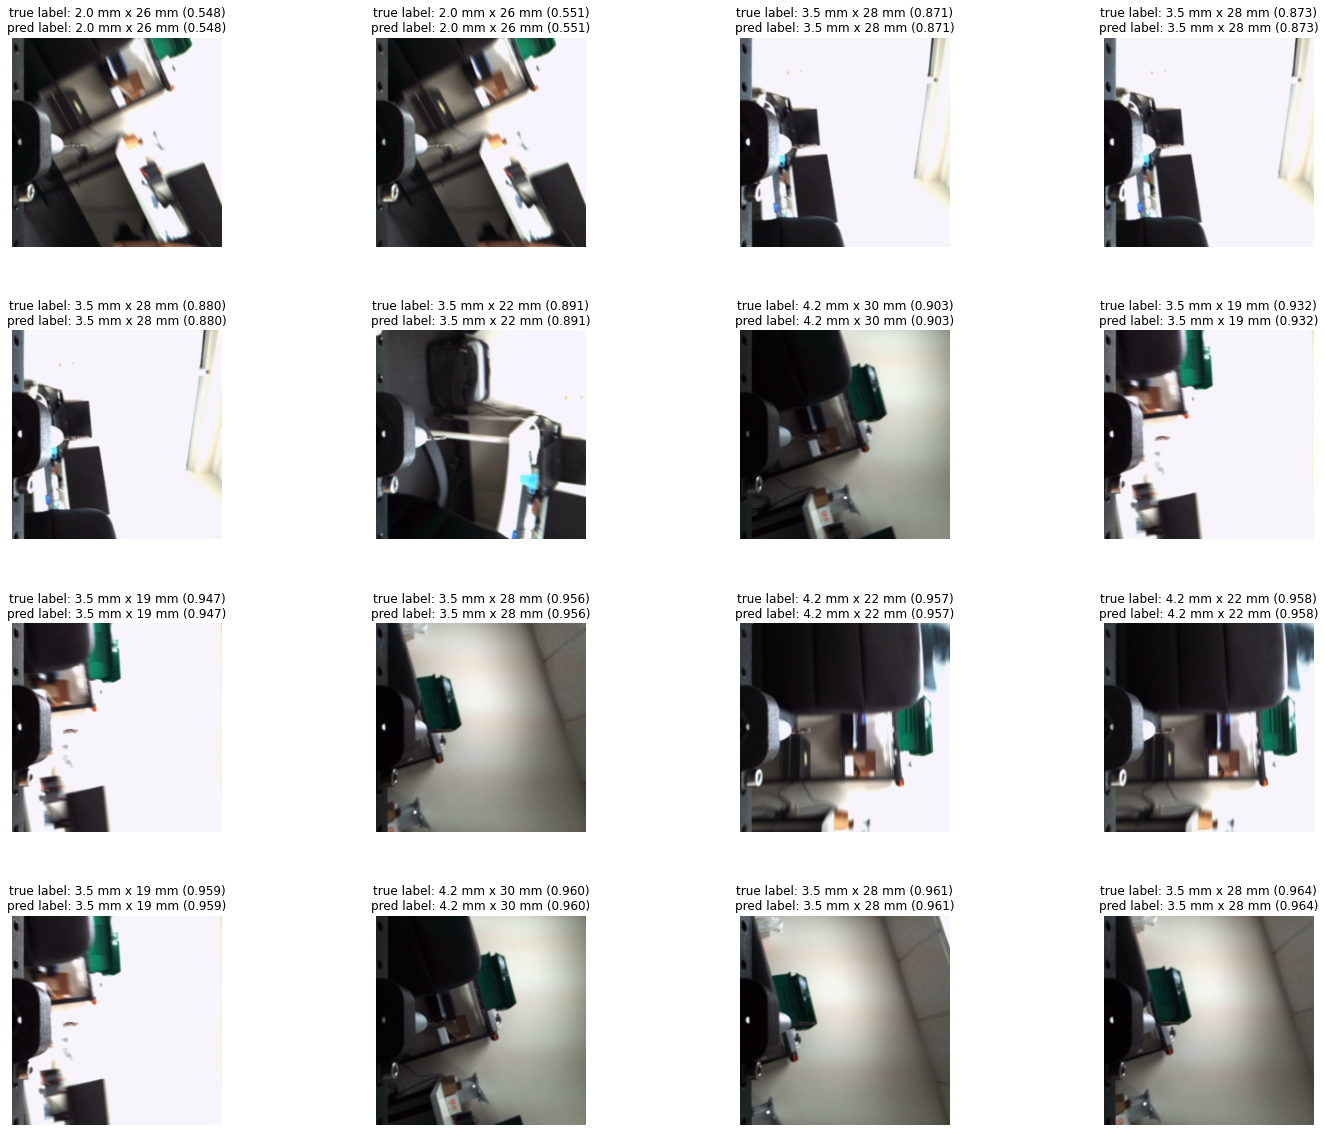

In [85]:
N_IMAGES = 20

plot_most_incorrect(correct_examples, classes, N_IMAGES)

We can also get the representations from the model in order to perform some dimensionality reduction techniques.

Lets get the final representation of the model

In [86]:
def get_representations(model, iterator):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            outputs.append(y_pred.cpu())
            labels.append(y)
        
    outputs = torch.cat(outputs, dim = 0)
    labels = torch.cat(labels, dim = 0)

    return outputs, labels

In [87]:
outputs, labels = get_representations(model, train_iterator)

We can then perform PCA on these representations to plot them in two dimensions.

In [88]:
def get_pca(data, n_components = 2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [89]:
def plot_representations(data, labels, classes, n_images = None):
            
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
                
    fig = plt.figure(figsize = (15, 15))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'hsv')
    handles, _ = scatter.legend_elements(num = None)
    legend = plt.legend(handles = handles, labels = classes)

We can clearly see that the classes are well seperated. 

Drills having kind of similar size (4.2 * 22 and 4.2 * 30) have close representations

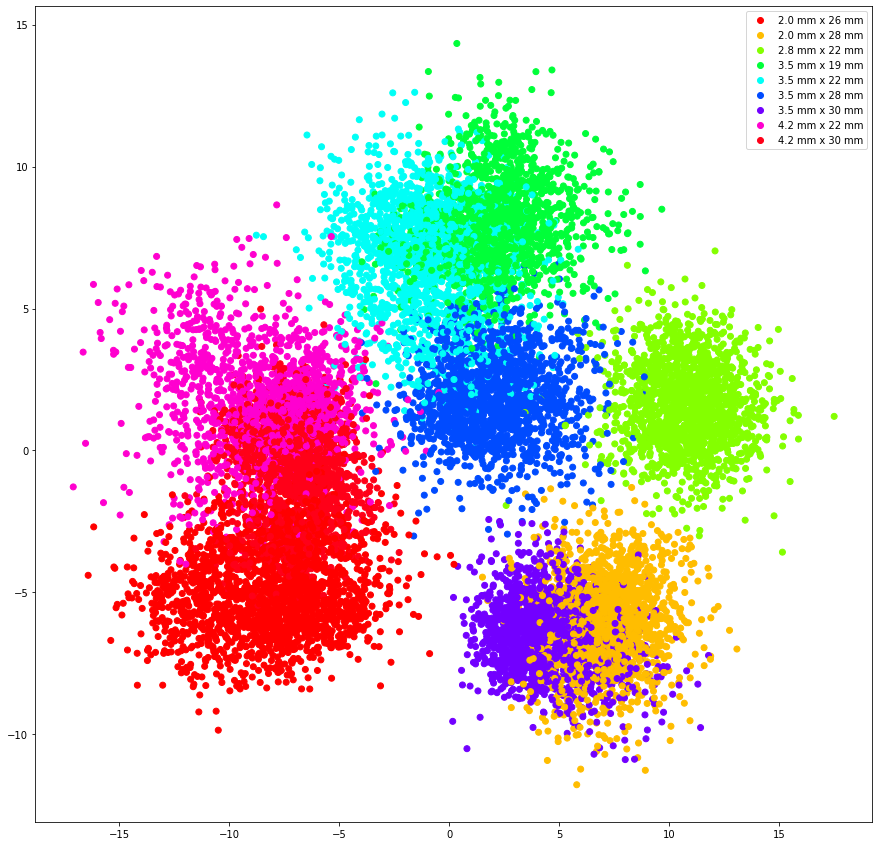

In [90]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels, classes)

Next up, we plot the t-SNE data.

In [91]:
def get_tsne(data, n_components = 2, n_images = None):
    
    if n_images is not None:
        data = data[:n_images]
        
    tsne = manifold.TSNE(n_components = n_components, random_state = 0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

we can clearly see that t-SNE is better than PCA in seperating classes

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


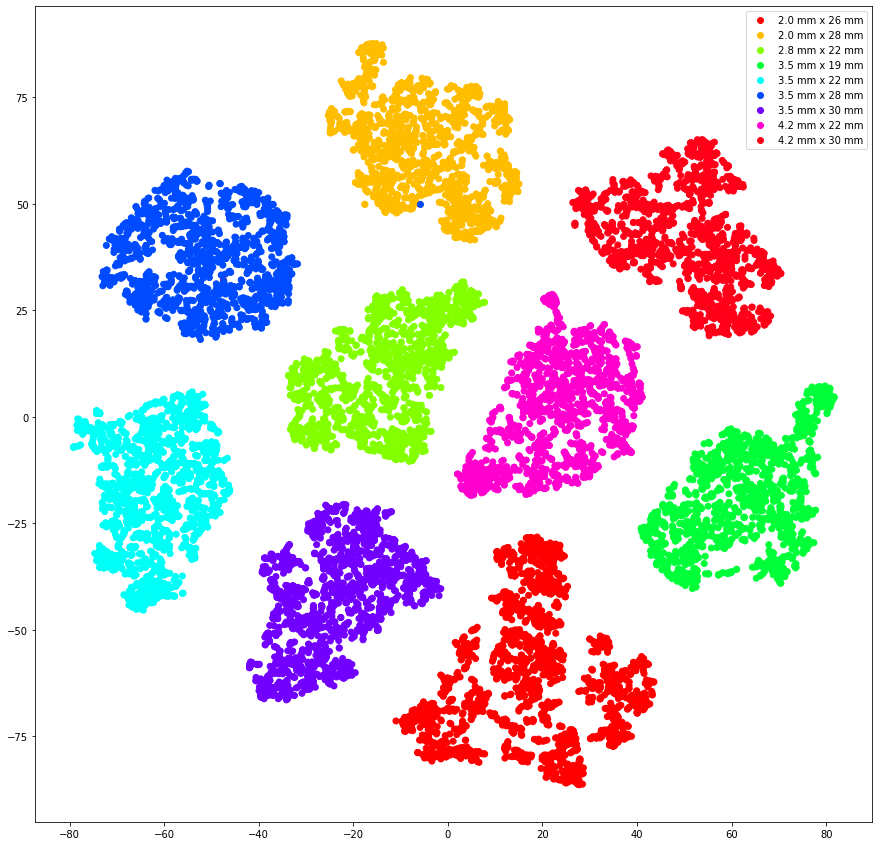

In [92]:
output_tsne_data = get_tsne(outputs)
plot_representations(output_tsne_data, labels, classes)

We can then plot what a few of the images look like after having gone through the first convolutional layer.

In [93]:
def plot_filtered_images(images, filters, n_filters = None, normalize = True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim = 0).cpu()
    filters = filters.cpu()

    if n_filters is not None:
        filters = filters[:n_filters]

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize = (30, 30))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(image.permute(1,2,0).numpy())
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]

            if normalize:
                image = normalize_image(image)

            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap = 'bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off');

    fig.subplots_adjust(hspace = -0.7)

We can see that the filters perform many different types of image processing - from edge detection to color inversion.

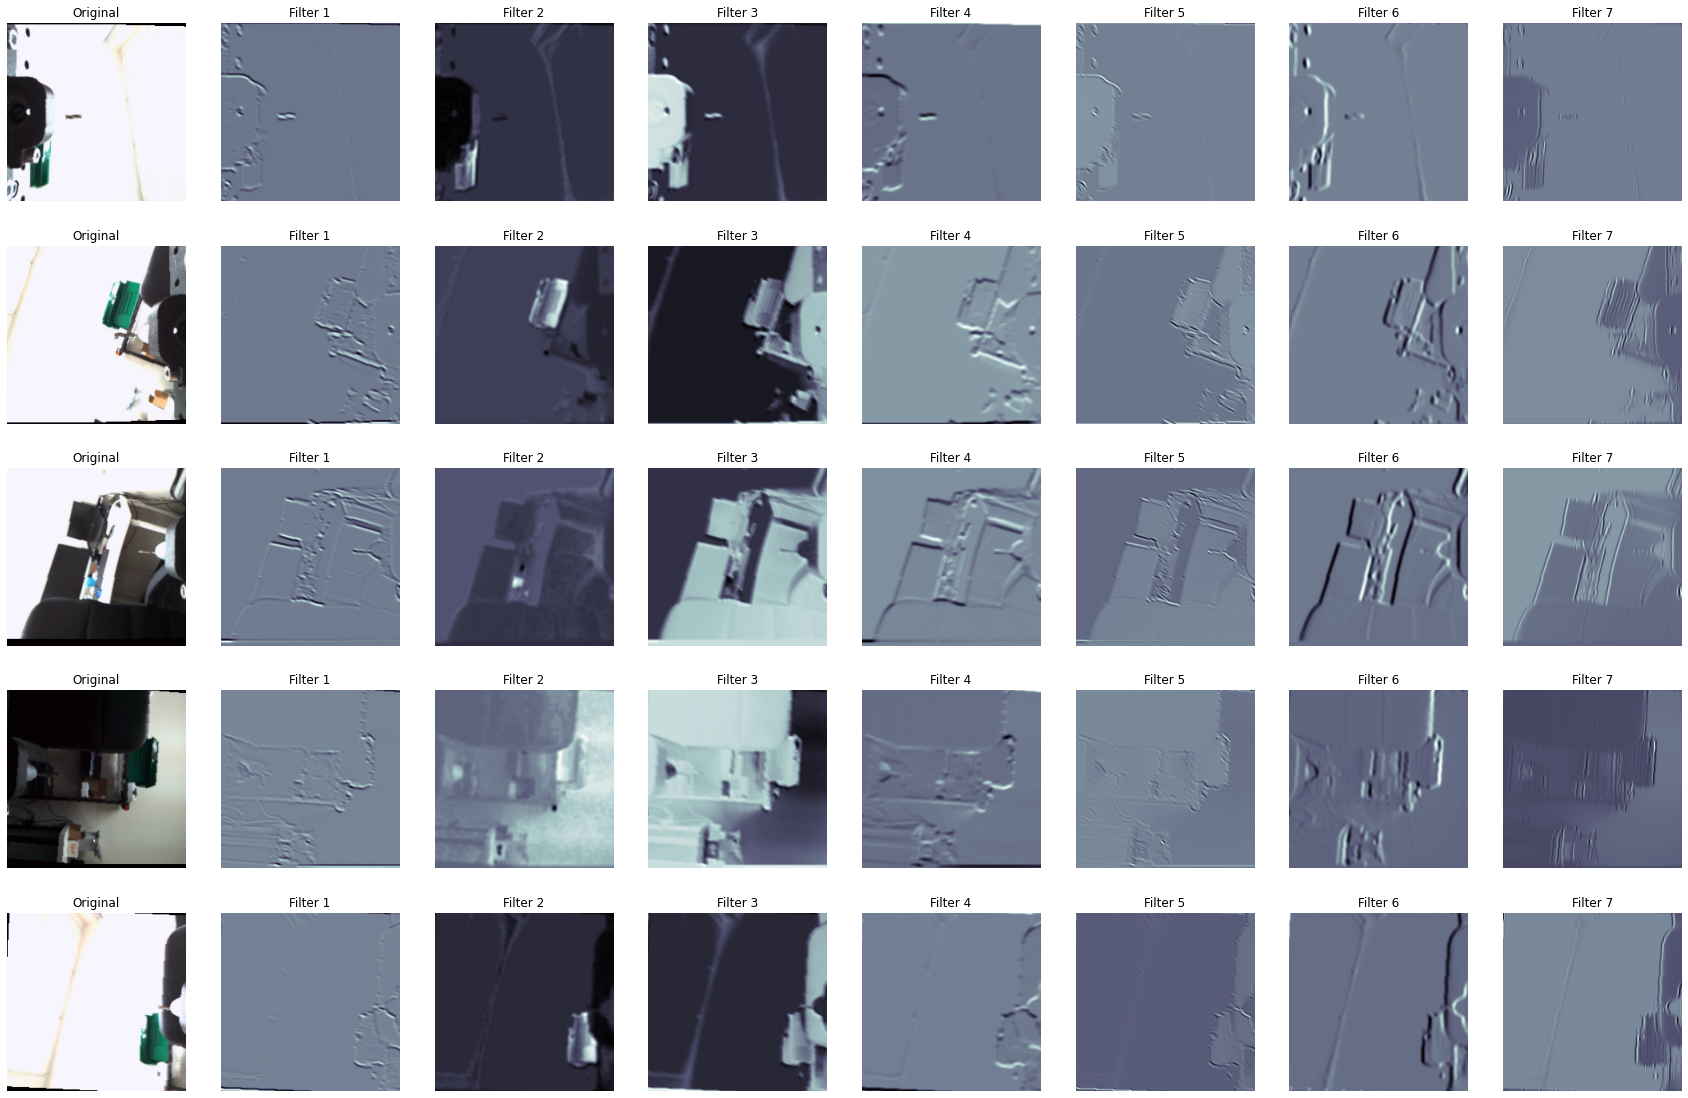

In [94]:
N_IMAGES = 5
N_FILTERS = 7

images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]
filters = model.conv1.weight.data

plot_filtered_images(images, filters, N_FILTERS)

Finally, we can plot the values of the filters themselves.

In [95]:
def plot_filters(filters, normalize = True):

    filters = filters.cpu()

    n_filters = filters.shape[0]

    rows = int(np.sqrt(n_filters))
    cols = int(np.sqrt(n_filters))

    fig = plt.figure(figsize = (30, 15))

    for i in range(rows*cols):

        image = filters[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(image.permute(1, 2, 0))
        ax.axis('off')
        
    fig.subplots_adjust(wspace = -0.9)

There are some interesting patterns contained in these filters, however all of these were already present in the pre-trained ResNet model.

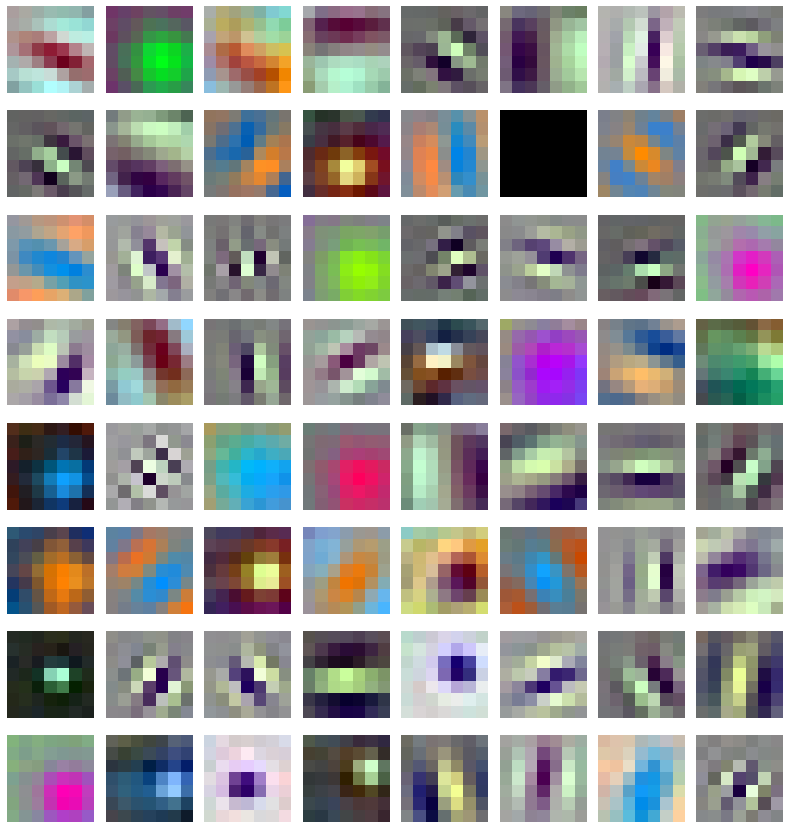

In [96]:
plot_filters(filters)

### Conclusion

From the results, we can clearly conclude that Resnet-50 is the optimal solution for this problem, as it is achieving high accuracy on both the train and test data.

We can try some alternatives like VGG, alexNet.. However, based on the literature, Resnet-50 has been the best-performing model so far.

#### Note
At the first iteration, I used Adam optimizer instead of SGD, however, the model was underfitting with a training accuracy equal to ~17%.